Steps:


1. Read data.
2. Train test splits.
3. Split train in multiple fragments 50, 100, ..., 20k


4. Train Ridge / dummy regressor on field.
5. Train NeRF on train split.
5. record the two performances on test set.

In [ ]:
import numpy as np
train_percentages = np.arange(10, 101, 10)

# 0. Data Preparation / Splits

In [1]:
# 1. Read data.
from utils.scripts.architectures.train_location_encoder import process_locations_visibility_data_frame
import numpy as np
import pandas as pd

data_loc = "./utils/assets/data"

vis_df_n, norm_params, non_empty_classes = process_locations_visibility_data_frame(f"{data_loc}/locations.csv")

vis_raw_df = pd.read_csv(f"{data_loc}/locations.csv")
np.random.seed(1)
vis_raw_df = vis_raw_df.sample(frac=1)

# 2. Train test splits.
np.random.seed(1)
visual_df = vis_df_n.sample(frac=1)
visual_df.to_json(f"{data_loc}/splits/full_dataset_{visual_df.shape[0]}.json", orient="records", indent=4)
test_df       = visual_df[:5000]
full_train_df = visual_df[5000:]
test_df.to_json(f"{data_loc}/splits/test_set_{test_df.shape[0]}.json", orient="records", indent=4)

# 3. Split train in multiple fragments 50, 100, ..., 20k
train_fractions = train_percentages/100#[1, .8, .6, .4, .2, .1]

for fraction in train_fractions:
    num_train_samples = int(fraction * full_train_df.shape[0])
    train_df = full_train_df[:num_train_samples]
    
    file_name = f"./utils/assets/data/splits/train_set_{int(fraction * 100)}-percent"
    train_df.to_json(f"{file_name}.json", orient="records", indent=4)
    
    vis_raw_df[5000:5000+num_train_samples].to_csv(f"{file_name}.csv", index=False)
    



# 1. Train simple ground truth interpolator

In [3]:
import pandas as pd
test_df  = pd.read_json(f"{data_loc}/splits/test_set_5000.json")

# train_percentage = 10

# train_df = pd.read_json(f"{data_loc}/splits/train_set_{train_percentage}-percent.json")


# import numpy as np

# train_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values.shape
# np.vstack(train_df["f_xyz"].values).shape

(2123, 4)

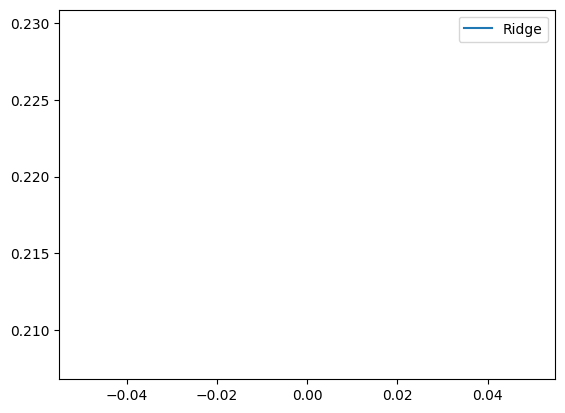

In [2]:
# 4. Train Ridge / dummy regressor on field.

from sklearn.linear_model import Ridge
import numpy as np
import matplotlib.pyplot as plt



# train_percentages = [10, 20, 40, 60, 80, 100]

r2_scores = []


# for i, percentage in tqdm(enumerate(train_percentages)):

for percentage in train_percentages:
    
    test_df  = pd.read_json(f"{data_loc}/splits/test_set_5000.json")
    train_df = pd.read_json(f"{data_loc}/splits/train_set_{percentage}-percent.json")

    X = train_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values
    y = np.vstack(train_df["f_xyz"].values)

    clf = Ridge(alpha=1.0)
    clf.fit(X, y)

    X_test = test_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values
    y_test = np.vstack(test_df["f_xyz"].values)

    r2_score = clf.score(X_test, y_test)
    r2_scores.append(r2_score)

    
vanilla_predictions = clf.predict(X_test)
vanilla_predictions.shape    

plt.plot(r2_scores, label="Ridge")
plt.legend()
plt.show()



# 2. Train `NeRF` interpolator.

In [116]:
from utils.scripts.architectures.train_location_encoder \
import get_location_visibility_encoder, process_locations_visibility_data_frame\
, get_location_visibility_loaders, run_one_epoch_location_encoder, train_model_on_data


from utils.scripts.architectures.torch_nerf_src import network

import numpy as np
import pandas as pd
import torch


from tqdm.notebook import tqdm

data_loc   = "./utils/assets/data"
ne  = 350
sli = [0,1,5,6] #[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']


# train_percentages = np.arange(10, 101, 10)

for i, percentage in enumerate(train_percentages):
    print(f"{i+1}. Training on {percentage}% of the data:")
    file_store = f"{data_loc}/splits/train_set_{percentage}-percent.csv"
    model_name = f"encoder_{percentage}.pt"
    # Train NeRF for ne epochs
    encoder_net, tr_losses_history, test_losses_history, vdf \
    = train_model_on_data(data_path=file_store, num_epochs=ne, selected_label_indexes=sli, model_name=model_name)




1. Training on 10% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 1,698 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.15626 - test loss 0.20956: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:02<00:00,  5.63it/s]


Model weights saved at:
	./utils/assets/data/splits/models/encoder_10.pt

Training for 
	350     epochs took: 
	62s, for an average of: 
	0.2s per epoch.
2. Training on 20% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 3,396 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.13251 - test loss 0.17443: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [02:18<00:00,  2.53it/s]


Model weights saved at:
	./utils/assets/data/splits/models/encoder_20.pt

Training for 
	350     epochs took: 
	138s, for an average of: 
	0.4s per epoch.
3. Training on 30% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 5,095 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.12003 - test loss 0.17384: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [03:30<00:00,  1.67it/s]


Model weights saved at:
	./utils/assets/data/splits/models/encoder_30.pt

Training for 
	350     epochs took: 
	210s, for an average of: 
	0.6s per epoch.
4. Training on 40% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 6,793 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.11689 - test loss 0.16071: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [04:46<00:00,  1.22it/s]


Model weights saved at:
	./utils/assets/data/splits/models/encoder_40.pt

Training for 
	350     epochs took: 
	286s, for an average of: 
	0.8s per epoch.
5. Training on 50% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 8,492 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.11651 - test loss 0.14906: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [05:56<00:00,  1.02s/it]


Model weights saved at:
	./utils/assets/data/splits/models/encoder_50.pt

Training for 
	350     epochs took: 
	357s, for an average of: 
	1.0s per epoch.
6. Training on 60% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 10,191 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.11035 - test loss 0.14591: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [07:09<00:00,  1.23s/it]


Model weights saved at:
	./utils/assets/data/splits/models/encoder_60.pt

Training for 
	350     epochs took: 
	430s, for an average of: 
	1.2s per epoch.
7. Training on 70% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 11,889 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.11217 - test loss 0.14889: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [08:37<00:00,  1.48s/it]


Model weights saved at:
	./utils/assets/data/splits/models/encoder_70.pt

Training for 
	350     epochs took: 
	517s, for an average of: 
	1.5s per epoch.
8. Training on 80% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 13,588 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.10583 - test loss 0.13912: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [09:58<00:00,  1.71s/it]


Model weights saved at:
	./utils/assets/data/splits/models/encoder_80.pt

Training for 
	350     epochs took: 
	598s, for an average of: 
	1.7s per epoch.
9. Training on 90% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 15,286 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.10413 - test loss 0.13661: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [10:42<00:00,  1.84s/it]


Model weights saved at:
	./utils/assets/data/splits/models/encoder_90.pt

Training for 
	350     epochs took: 
	643s, for an average of: 
	1.8s per epoch.
10. Training on 100% of the data:
Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 16,985 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.10339 - test loss 0.13922: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [11:39<00:00,  2.00s/it]

Model weights saved at:
	./utils/assets/data/splits/models/encoder_100.pt

Training for 
	350     epochs took: 
	699s, for an average of: 
	2.0s per epoch.


# 2.b Compute `NeRF` predictions

In [117]:
from tqdm import tqdm
# train_percentages = np.arange(10, 101, 10)

# Initialize NeRFS model with weights of trainedNeRF model
model_path      = "./utils/assets/data/splits/models"
info_dict       = pd.read_json(f"{model_path}/training_info_50.json").to_dict()[0]
norm_params                = (torch.tensor(info_dict["xyz_centroid"]), torch.tensor(info_dict["xyz_max-min"]), torch.tensor(info_dict["xyzh_centroid"]), torch.tensor(info_dict["xyzh_max-min"]))
    
nerf_predictions_per_percentage = {}
nerf_predictions = []

for i, percentage in tqdm(enumerate(train_percentages)):
    trained_encoder            = network.nerfs.NeRFS(norm_params=norm_params, surface_type="square", pos_dim=info_dict["enc_input_size"], output_dim=info_dict["num_present_classes"],  view_dir_dim=info_dict["enc_input_size"])
    trained_encoder.load_state_dict(torch.load(f"{model_path}/encoder_{percentage}.pt"))
    
    for i in range(test_df.shape[0]):
        xyz  = torch.tensor(test_df.values[:,:6][i].astype(float)[:3])
        xyzh = torch.tensor(test_df.values[:,:6][i].astype(float)[3:])

        _,_, prediction = trained_encoder.predict_from_raw(xyz, xyzh)


        nerf_predictions.append(prediction.detach().numpy()[0])
    
    nerf_predictions = np.vstack(nerf_predictions)
    nerf_predictions_per_percentage[percentage] = nerf_predictions
    nerf_predictions = []
    
# nerf_predictions.shape

0it [00:00, ?it/s]

Surface not initialized properly. Can only predict from raw position and direction.


1it [00:16, 16.82s/it]

Surface not initialized properly. Can only predict from raw position and direction.


2it [00:33, 16.57s/it]

Surface not initialized properly. Can only predict from raw position and direction.


3it [00:49, 16.40s/it]

Surface not initialized properly. Can only predict from raw position and direction.


4it [01:05, 16.23s/it]

Surface not initialized properly. Can only predict from raw position and direction.


5it [01:21, 16.34s/it]

Surface not initialized properly. Can only predict from raw position and direction.


6it [01:39, 16.90s/it]

Surface not initialized properly. Can only predict from raw position and direction.


7it [01:56, 16.83s/it]

Surface not initialized properly. Can only predict from raw position and direction.


8it [02:12, 16.52s/it]

Surface not initialized properly. Can only predict from raw position and direction.


9it [02:28, 16.40s/it]

Surface not initialized properly. Can only predict from raw position and direction.


10it [02:45, 16.57s/it]


# 3.  comparison between `NeRF` and vanilla interpolator

# Try a number of different vanilla regressors:

In [118]:
# 4. Train Ridge / dummy regressor on field.

import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

vanilla_predictors = {
                    "1 Neighbor" : KNeighborsRegressor(n_neighbors=1),\
                    "2 Neighbors" : KNeighborsRegressor(n_neighbors=2),\
                    "3 Neighbors" : KNeighborsRegressor(n_neighbors=5),\
                    "4 Neighbors" : KNeighborsRegressor(n_neighbors=10),\
                    "10 Neighbors" : KNeighborsRegressor(n_neighbors=15),\
#                     "20 Neighbors" : KNeighborsRegressor(n_neighbors=20),\
#                     "50 Neighbors" : KNeighborsRegressor(n_neighbors=50),\
#                      "Random Forest" : RandomForestRegressor(max_depth=7, random_state=0),
#                      "Ridge" : Ridge(alpha=1.0),\
                     }

predictors_map = {}

for predictor_name in vanilla_predictors:
    print(f"{predictor_name} test:")
    
    predictor = vanilla_predictors[predictor_name]
    
    vanilla_predictions_per_percentage = {}
    vanilla_predictions = []


    test_df  = pd.read_json(f"{data_loc}/splits/test_set_5000.json")
    X_test = test_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values
    y_test = np.vstack(test_df["f_xyz"].values)

    for percentage in tqdm(train_percentages):

        train_df = pd.read_json(f"{data_loc}/splits/train_set_{percentage}-percent.json")

        X = train_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values
        y = np.vstack(train_df["f_xyz"].values)

        predictor.fit(X, y)

        vanilla_predictions = predictor.predict(X_test)

        vanilla_predictions_per_percentage[percentage] = vanilla_predictions
    
    predictors_map[predictor_name] = vanilla_predictions_per_percentage


1 Neighbor test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]


2 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.69it/s]


3 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]


4 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


10 Neighbors test:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]


# 3.b. Criterion comparisons between NeRF and vanilla interpolator¶

10it [00:00, 8511.17it/s]
10it [00:00, 8525.01it/s]
10it [00:00, 9515.21it/s]


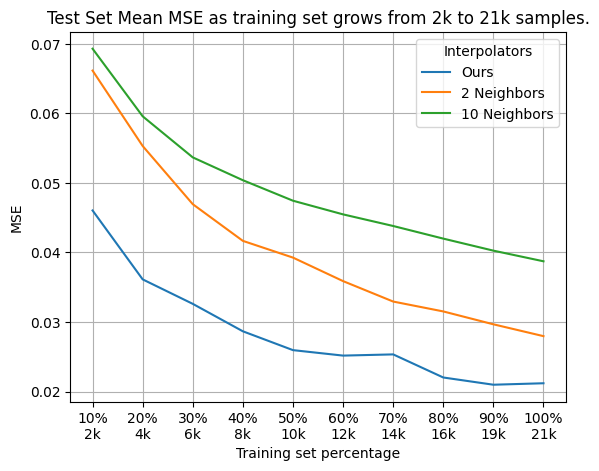

In [119]:
import torch
criterion   = torch.nn.MSELoss(reduction='none')
y_test = np.vstack(test_df["f_xyz"].values)

nerf_mses = []
vanilla_mses = []
vanilla_mses_per_predictor = {}

# Compute criterion for both NERF and Vanilla.
#Needs to already be computed:
#1. vanilla_predictions_per_percentage
#2. nerf_predictions_per_percentage

for i, percentage in tqdm(enumerate(train_percentages)):
    nerf_predictions = nerf_predictions_per_percentage[percentage]
    nerf_mse         = criterion(torch.tensor(nerf_predictions), torch.tensor(y_test)).mean()

    nerf_mses.append(nerf_mse.detach().numpy())

for predictor_name in list(predictors_map.keys()):#[::-1]:
    if predictor_name in ["Ridge", "Random Forest", "4 Neighbors", "3 Neighbors", "1 Neighbor"]:
        continue
    
    vanilla_predictions_per_percentage = predictors_map[predictor_name]
    
    for i, percentage in tqdm(enumerate(train_percentages)):
        vanilla_predictions = vanilla_predictions_per_percentage[percentage]
        vanilla_mse         = criterion(torch.tensor(vanilla_predictions), torch.tensor(y_test)).mean()

        vanilla_mses.append(vanilla_mse.detach().numpy())
        
    vanilla_mses_per_predictor[predictor_name] = vanilla_mses
    vanilla_mses = []

import matplotlib.pyplot as plt

plt.plot(nerf_mses, label="Ours")
for predictor_name in vanilla_mses_per_predictor:
    vanilla_mses = vanilla_mses_per_predictor[predictor_name]
    plt.plot(vanilla_mses, label=predictor_name)
plt.legend(title="Interpolators")

num_train_samples_str = (train_df.shape[0] * train_percentages/100).astype(int).astype(str)
num_samples_in_k      = [f"{s[:-3]}k" for s in num_train_samples_str]

plt.xticks(np.arange(len(nerf_mses)), labels=[f"{tp}%\n{nk}" for \
                                              tp, nk in zip(train_percentages, num_samples_in_k)])
plt.xlabel("Training set percentage")
plt.ylabel("MSE")
plt.title("Test Set Mean MSE as training set grows from 2k to 21k samples.")
plt.grid()


plt.show()

In [120]:
vanilla_mses_per_predictor, nerf_mses

({'2 Neighbors': [array(0.06613313),
   array(0.05529187),
   array(0.04693144),
   array(0.04165714),
   array(0.0392525),
   array(0.03587293),
   array(0.03293495),
   array(0.03151467),
   array(0.02966525),
   array(0.027962)],
  '10 Neighbors': [array(0.06927672),
   array(0.05956095),
   array(0.05365669),
   array(0.0503753),
   array(0.0474295),
   array(0.04546499),
   array(0.04379572),
   array(0.04198186),
   array(0.04025225),
   array(0.03872206)]},
 [array(0.04602801),
  array(0.0361216),
  array(0.03260414),
  array(0.02865824),
  array(0.02595226),
  array(0.02516615),
  array(0.02533949),
  array(0.02201948),
  array(0.02098029),
  array(0.02119102)])

In [51]:
num_train_samples_str = (train_df.shape[0] * train_percentages/100).astype(int).astype(str)
num_samples_in_k = [f"{s[:-3]}k" for s in num_train_samples_str]
num_samples_in_k

['2k', '4k', '6k', '8k', '10k', '12k', '14k', '16k', '19k', '21k']

In [49]:
train_percentages, (train_df.shape[0] * train_percentages/100).astype(int).astype(str)

(array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 array(['2123', '4246', '6369', '8492', '10616', '12739', '14862', '16985', '19108', '21232'], dtype='<U21'))

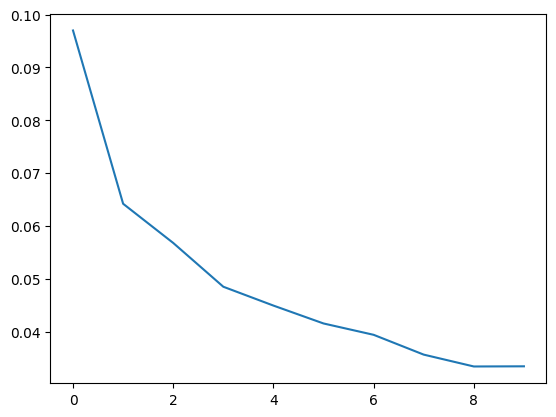

In [36]:
criterion(torch.tensor(nerf_predictions), torch.tensor(y_test)).mean()\
          , criterion(torch.tensor(vanilla_predictions), torch.tensor(y_test)).mean()

(tensor(0.0420, dtype=torch.float64), tensor(0.1628, dtype=torch.float64))

In [39]:
criterion(torch.tensor(nerf_predictions), torch.tensor(y_test)).mean(axis=1).mean()\
          , criterion(torch.tensor(vanilla_predictions), torch.tensor(y_test)).mean(axis=1).mean()

(tensor(0.0420, dtype=torch.float64), tensor(0.1628, dtype=torch.float64))

In [38]:
criterion(torch.tensor(nerf_predictions), torch.tensor(y_test)).mean(axis=0)\
          , criterion(torch.tensor(vanilla_predictions), torch.tensor(y_test)).mean(axis=0)

(tensor([0.0762, 0.0137, 0.0344, 0.0437], dtype=torch.float64),
 tensor([0.3179, 0.0571, 0.0746, 0.2015], dtype=torch.float64))

# 4. Replicate interpolation test for multiple training percentages and models.

# Drafts

In [33]:
criterion   = torch.nn.MSELoss(reduction='none')

criterion(torch.tensor(nerf_predictions[0]), torch.tensor(y_test[0]))\
          , criterion(torch.tensor(vanilla_predictions[0]), torch.tensor(y_test[0])),\
criterion(torch.tensor(nerf_predictions[0]), torch.tensor(y_test[0])).mean()\
          , criterion(torch.tensor(vanilla_predictions[0]), torch.tensor(y_test[0])).mean()

(tensor([4.7924e-03, 1.8183e-07, 2.3490e-02, 8.3328e-04], dtype=torch.float64),
 tensor([2.6367, 0.0028, 0.2110, 1.0106], dtype=torch.float64),
 tensor(0.0073, dtype=torch.float64),
 tensor(0.9653, dtype=torch.float64))

In [29]:
nerf_predictions[0], vanilla_predictions[0], y_test[0]

(array([ 0.8190328 , -0.9995736 , -0.8460536 , -0.91780937], dtype=float32),
 array([-0.735547  , -0.94720399, -0.54001446,  0.11634165]),
 array([ 0.88825989, -1.        , -0.99931717, -0.88894272]))

# Test `NeRFS` and `NeRF` return the same resutls

In [44]:
import torch

xyz  = torch.tensor(vdf.values[:,:6][0].astype(float)[:3])
xyzh = torch.tensor(vdf.values[:,:6][0].astype(float)[3:])

#1. NeRF - !needs normalized inputs.
norm_pos = (xyz - norm_params[0]) / norm_params[1]
pos      = norm_pos.unsqueeze(0)
view_dir = (xyzh - norm_params[2]) / norm_params[3]
view_dir = view_dir.unsqueeze(0)

print("NeRF prediction")
print(xyz, xyzh, encoder_net(pos, view_dir, from_raw=True)) #NeRF needs normalized inputs.


#2. NeRFS 
print("\nNeRFS prediction")
print(trained_encoder.predict_from_raw(xyz, xyzh))

NeRF prediction
tensor([2152.9542,   23.2385,  958.9914], dtype=torch.float64) tensor([ 7.3868, 80.1305, -7.2787], dtype=torch.float64) tensor([[-0.4327, -0.7639, -0.6330, -0.2706]], grad_fn=<TanhBackward0>)

NeRFS prediction
(tensor([2152.9542,   23.2385,  958.9914], dtype=torch.float64), tensor([ 7.3868, 80.1305, -7.2787], dtype=torch.float64), tensor([[-0.4327, -0.7639, -0.6330, -0.2706]], grad_fn=<TanhBackward0>))


In [ ]:

train_df[["xn", "yn", "zn", "xhn", "yhn", "zhn"]].values.shape
np.vstack(train_df["f_xyz"].values).shape

In [ ]:

n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
clf = Ridge(alpha=1.0)
clf.fit(X, y)

In [ ]:
# 4. Train Ridge / dummy regressor on field.
# 5. Train NeRF on train split.
# 5. record the two performances on test set.